# Project Title
Recognising hate speech on twitter (vs offensive language)

### Data description
The dataset contains 24,783 tweets by the twitter users. -- To be fill --

***Data Dictionary***

Data Description:
- Total Count (int64): The total number of instances that include hate speech, offensive language, and non-offensive tweets.
- Hate Speech Count (int64): The number of times the tweet was judged by CrowdFlower users as containing hate speech.
Offensive Language Count (int64): The number of times the tweet was judged by CrowdFlower users as containing offensive language.
- Neither Count (int64): The number of times the tweet was judged by CrowdFlower users as neither offensive nor non-offensive.
- Class (class label): A categorical label assigned to each tweet:
    - Class 0 represents hate speech.
    - Class 1 represents offensive language.
    - Class 2 represents tweets that are neither offensive nor non-offensive.
- Tweet (string): The text of the analysed tweet.



## Part 1: Importing Dataset

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Pre-processing
import re
from nltk.tokenize import word_tokenize      #to divide strings into lists of substrings
from nltk.stem import WordNetLemmatizer      #to link words with similar meanings to one word.
from nltk.corpus import stopwords            #to filter out useless data
import nltk
nltk.download('wordnet')
nltk.download('punkt')
stopword = set(stopwords.words('english'))
import string
import emoji

#imports for wordcloud visualization
from wordcloud import WordCloud
from PIL import Image
import requests

# Oversampling
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# Count vectorization and TDIF Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer


# Splitting and Oversampling of data
from sklearn.model_selection import train_test_split

# Modelling
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# CountVectorizer SVM
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

# TDIF SVM
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score


[nltk_data] Downloading package wordnet to C:\Users\Bodine
[nltk_data]     Stubbé\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Bodine
[nltk_data]     Stubbé\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
#set first col as index
main_data = pd.read_csv("Data/labeled_data.csv", index_col=0)
main_data.head()

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


### Importing the Dataset

In [3]:
main_data.info()
#dataframe informationk


<class 'pandas.core.frame.DataFrame'>
Int64Index: 24783 entries, 0 to 25296
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   count               24783 non-null  int64 
 1   hate_speech         24783 non-null  int64 
 2   offensive_language  24783 non-null  int64 
 3   neither             24783 non-null  int64 
 4   class               24783 non-null  int64 
 5   tweet               24783 non-null  object
dtypes: int64(5), object(1)
memory usage: 1.3+ MB


In [4]:
#add a column num_chars (number of characters)
main_data["num_chars"] = main_data['tweet'].apply(len)
#add a column num_words (number of words)
main_data["num_words"] = main_data['tweet'].apply(lambda x: len(str(x).split()))
#add a column avg_word_length (average word length)
main_data["avg_word_length"] = main_data['tweet'].apply(lambda x: sum(len(word) for word in str(x).split()) / len(str(x).split()) if len(str(x).split()) > 0 else 0)


In [5]:
main_data.describe()
# Descriptive statistics

,count,hate_speech,offensive_language,neither,class,num_chars,num_words,avg_word_length
count,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000
mean,3.243473,0.280515,2.413711,0.549247,1.110277,85.523625,14.117016,5.349873
std,0.883060,0.631851,1.399459,1.113299,0.462089,41.646293,6.825525,1.835783
min,3.000000,0.000000,0.000000,0.000000,0.000000,5.000000,1.000000,1.653846
25%,3.000000,0.000000,2.000000,0.000000,1.000000,52.000000,9.000000,4.240690
50%,3.000000,0.000000,3.000000,0.000000,1.000000,81.000000,13.000000,4.900000
75%,3.000000,0.000000,3.000000,0.000000,1.000000,119.000000,19.000000,5.944444
max,9.000000,7.000000,9.000000,9.000000,2.000000,756.000000,52.000000,57.000000


<Figure size 640x480 with 0 Axes>

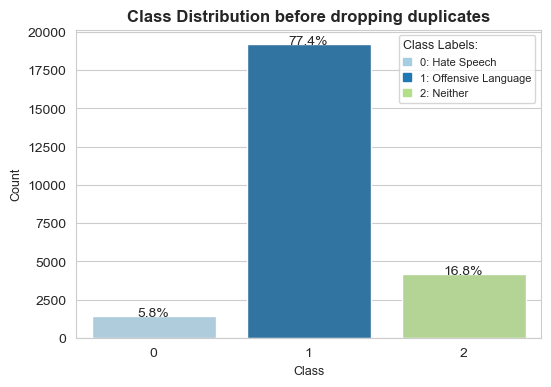

In [6]:
#Visualize class distribution to check for class imbalance
from matplotlib.patches import Rectangle

# Count the frequency of each class
class_counts = main_data['class'].value_counts()

#set seaborn aesthetics
palette = sns.color_palette("Paired", len(class_counts))
sns.set_style("whitegrid")
sns.despine(left=True, bottom=True)

#plot
plt.figure(figsize=(6, 4))
ax = sns.barplot(x=class_counts.index, y=class_counts.values, palette=palette)
legend_labels = ['0: Hate Speech', '1: Offensive Language', '2: Neither']
legend_handles = [Rectangle((0, 0), 1, 1, color=palette[i], label=label) for i, label in enumerate(legend_labels)]
ax.legend(handles=legend_handles, fontsize=8, handlelength=0.7, title="Class Labels:", alignment='left', title_fontsize=9)

# Total number of instances
total = float(sum(class_counts.values))

# Annotate each bar with the percentage value
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
            height + 3, 
            '{:1.1f}%'.format(100 * height / total),
            ha="center")
    
plt.title('Class Distribution before dropping duplicates', weight='bold')
plt.xlabel('Class', size=9)
plt.ylabel('Count', size=9)
plt.show()

**Key Takeaway**: massive class imbalance -> dataset is biased toward offensive tweets

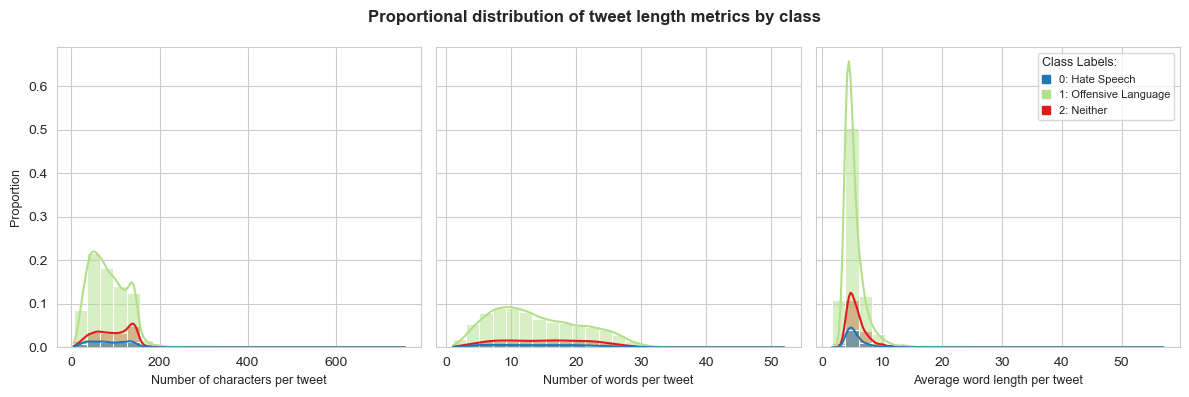

In [7]:
#Visualize proportional distribution of the 3 length metrics for each class
palette = sns.color_palette("Paired")
selected_colors = [palette[1], palette[2], palette[5]] 

fig, axs = plt.subplots(1,3,figsize=(12,4), sharey=True)
for dist_metric, ax in zip(['num_chars', 'num_words', 'avg_word_length'], axs.flatten()):
    sns.histplot(data=main_data, x=dist_metric, hue='class', stat='proportion', bins=25, kde=True, palette=selected_colors, ax=ax, legend=False)

legend_labels = ['0: Hate Speech', '1: Offensive Language', '2: Neither']
legend_handles = [Rectangle((0, 0), 1, 1, color=selected_colors[i], label=label) for i, label in enumerate(legend_labels)]
axs[2].legend(handles=legend_handles, fontsize=8, handlelength=0.7, title="Class Labels:", alignment='left', title_fontsize=9)

axs[0].set_xlabel('Number of characters per tweet', size=9)
axs[1].set_xlabel('Number of words per tweet', size=9)
axs[2].set_xlabel('Average word length per tweet', size=9)
axs[0].set_ylabel('Proportion', size=9)
plt.suptitle('Proportional distribution of tweet length metrics by class', weight='bold')
plt.tight_layout() 

plt.show()

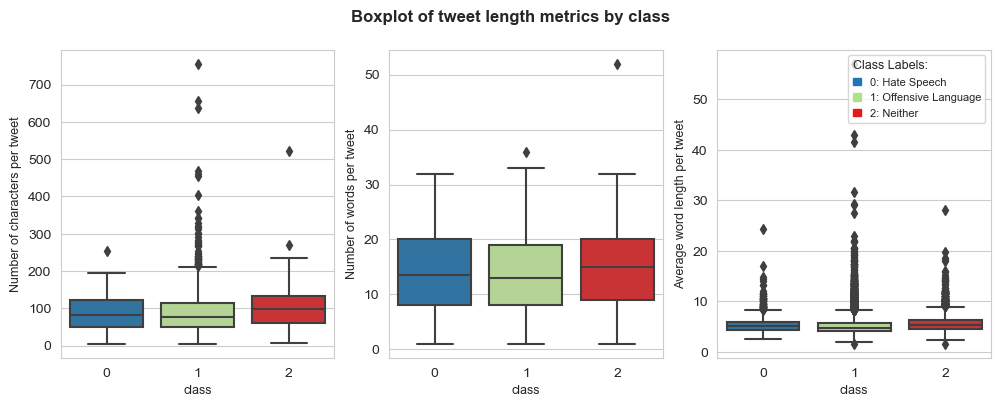

In [8]:
#boxplot visualizing tweet length metrics by class
palette = sns.color_palette("Paired")
selected_colors = [palette[1], palette[2], palette[5]]  

fig, axs = plt.subplots(1,3,figsize=(12,4))
for dist_metric, ax in zip(['num_chars', 'num_words', 'avg_word_length'], axs.flatten()):
    sns.boxplot(x='class', y=dist_metric, data=main_data, palette=selected_colors, ax=ax)
    ax.set_xlabel('class', size=9)

legend_labels = ['0: Hate Speech', '1: Offensive Language', '2: Neither']
legend_handles = [Rectangle((0, 0), 1, 1, color=selected_colors[i], label=label) for i, label in enumerate(legend_labels)]
plt.legend(handles=legend_handles, fontsize=8, handlelength=0.7, title="Class Labels:", alignment='left', title_fontsize=9)

axs[0].set_ylabel('Number of characters per tweet', size= 9)
axs[1].set_ylabel('Number of words per tweet', size= 9)
axs[2].set_ylabel('Average word length per tweet', size= 9)
plt.suptitle('Boxplot of tweet length metrics by class', weight='bold')
plt.tight_layout
plt.show()

Adding a new column to this dataset as labels which will contain the values as:

1. Hate Speech
2. Offensive Language
3. No Hate and Offensive

In [9]:
# main_data["labels"] = main_data["class"].map({0: "Hate Speech", 
#                                     1: "Offensive Language", 
#                                     2: "No Hate and Offensive"})
main_data.head()

,count,hate_speech,offensive_language,neither,class,tweet,num_chars,num_words,avg_word_length
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,140,25,4.640000
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,85,16,4.375000
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,120,21,4.761905
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,62,9,6.000000
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,137,26,4.307692


In [10]:
main_data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 24783 entries, 0 to 25296
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   count               24783 non-null  int64  
 1   hate_speech         24783 non-null  int64  
 2   offensive_language  24783 non-null  int64  
 3   neither             24783 non-null  int64  
 4   class               24783 non-null  int64  
 5   tweet               24783 non-null  object 
 6   num_chars           24783 non-null  int64  
 7   num_words           24783 non-null  int64  
 8   avg_word_length     24783 non-null  float64
dtypes: float64(1), int64(7), object(1)
memory usage: 1.9+ MB


In [11]:
main_data["tweet"].iloc[2]

'!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit'

Now we only select the tweet and labels columns for the rest of the task of training a hate speech detection model:

i.e. Selecting only the relevant columns which are tweets and labels

In [12]:
relevant_data = main_data[["tweet", "class"]]
relevant_data.head()

,tweet,class
0,!!! RT @mayasolovely: As a woman you shouldn't...,2
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1


In [13]:
#getting the sum of duplicates
relevant_data.duplicated().sum()

0

## Part 2: Data Preprocessing

In [14]:
# import re
# from nltk.tokenize import word_tokenize      #to divide strings into lists of substrings
# from nltk.stem import WordNetLemmatizer      #to link words with similar meanings to one word.
# from nltk.corpus import stopwords            #to filter out useless data
# import nltk
# nltk.download('wordnet')
# nltk.download('punkt')
# stopword = set(stopwords.words('english'))
# import string

In [15]:
# import emoji

def convert_emoji_to_unicode_to_word(tweet): 
    
    emoji_list = re.findall(r'&#\d+;',tweet)
    
    for emoji_str in emoji_list:
        decimal_code_point = int(emoji_str.replace("&#", "").replace(";",""))
        tweet = tweet.replace(emoji_str, emoji.demojize(chr(decimal_code_point)).replace("_"," ")+" ")
    return tweet

In [16]:
def clean(text):
    #Convert the tweet to lowercase
    text = str(text).lower()
    
    if re.match("&#\d+;", text):
        text = convert_emoji_to_unicode_to_word(text)
        
    if re.match("^[^&][\S]+", text):
        text = re.sub(r'#', ' ', text)
    text = re.sub(r'&[a-z0-9]+;', '', text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    # text = re.sub(r"\@w+|\#",'',text)
    #remove username from the tweet starting with @
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r"[^\w\s]",'',text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    # #remove "rt" from the tweet
    text = re.sub(r'rt ', '', text, flags=re.IGNORECASE)
    # Remove all special characters except for astrisk to preserve the meaning of the tweet
    text = re.sub(r'[^a-z0-9*\s]', '', text)
    tweet_tokens = word_tokenize(text)
    filtered_tweets=[w for w in tweet_tokens if not w in stopword] #removing stopwords
    return " ".join(filtered_tweets)

In [17]:
# relevant_data.tweet = relevant_data['tweet'].apply(clean)
relevant_data = relevant_data.copy()
relevant_data.tweet = relevant_data["tweet"].apply(clean)

In [18]:
relevant_data.head()

,tweet,class
0,woman shouldnt complain cleaning house man alw...,2
1,boy dats coldtyga dwn bad cuffin dat hoe place,1
2,dawg ever fuck bitch stato cry confused shit,1
3,look like tranny,1
4,shit hear might true might faker bitch told ya,1


In [19]:
#getting the sum of duplicates
relevant_data.duplicated().sum()

869

In [20]:
duplicates = relevant_data[relevant_data.duplicated(keep='first')]
duplicates

,tweet,class
572,hoes aint loyal,1
892,porn android iphone ipad sex xxx desi paki,2
902,porn android iphone ipad sex xxx hairy hairy p...,1
1373,twitter rappers dm trash links,2
1479,way fuck ur bitch,1
...,...,...
25172,hoe,1
25237,give bitch inch rather,1
25261,yo hoe get slayed,1
25262,yo hoe get slayed,1


In [21]:
relevant_data["tweet"].iloc[1007]

'face tears joy face tears joy fucking god bruh birds southridge front house'

In [22]:
# #imports for wordcloud visualization
# from wordcloud import WordCloud
# from PIL import Image
# import requests

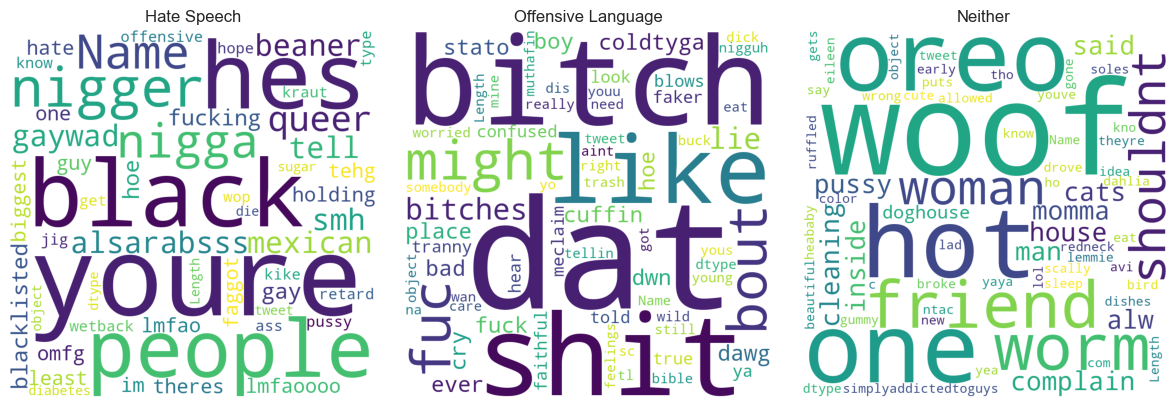

In [23]:
#wordclouds before removing duplicates

#pic = np.array(Image.open(requests.get('http://www.clker.com/cliparts/O/i/x/Y/q/P/yellow-house-hi.png',stream=True).raw))
fig, axs = plt.subplots(1,3,figsize=(12,4))

for category, ax in zip([0, 1, 2], axs.flatten()):
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',
                stopwords = stopword,
                min_font_size = 10,
                random_state=42, 
                max_words=500).generate(str(relevant_data.loc[relevant_data["class"]==category, 'tweet']))
    ax.imshow(wordcloud)
    ax.axis('off')

axs[0].set_title("Hate Speech")
axs[1].set_title("Offensive Language")
axs[2].set_title("Neither")

plt.tight_layout() 
plt.show()


In [24]:
# removing duplicate data
new_data = relevant_data.drop_duplicates("tweet")

In [25]:
# to see updated number of columns as duplicates entries are removed
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23866 entries, 0 to 25296
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   23866 non-null  object
 1   class   23866 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 559.4+ KB


<Figure size 640x480 with 0 Axes>

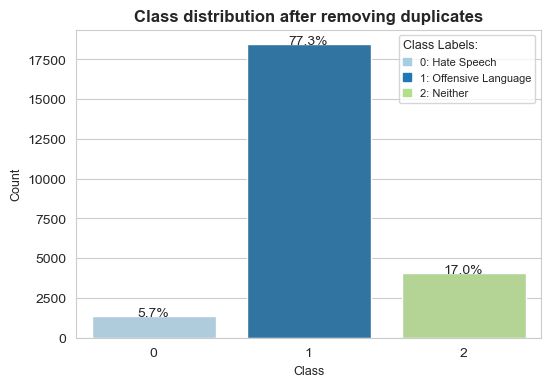

In [26]:
#class distribution after removing duplicates
class_counts = new_data['class'].value_counts()

palette = sns.color_palette("Paired", len(class_counts))
sns.set_style("whitegrid")
sns.despine(left=True, bottom=True)

#plot
plt.figure(figsize=(6, 4))
ax = sns.barplot(x=class_counts.index, y=class_counts.values, palette=palette)
legend_labels = ['0: Hate Speech', '1: Offensive Language', '2: Neither']
legend_handles = [Rectangle((0, 0), 1, 1, color=palette[i], label=label) for i, label in enumerate(legend_labels)]
ax.legend(handles=legend_handles, fontsize=8, handlelength=0.7, title="Class Labels:", alignment='left', title_fontsize=9)

# Total number of instances
total = float(sum(class_counts.values))

# Annotate each bar with the percentage value
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
            height + 3, 
            '{:1.1f}%'.format(100 * height / total),
            ha="center")
    
plt.title('Class distribution after removing duplicates', weight='bold')
plt.xlabel('Class', size=9)
plt.ylabel('Count', size=9)
plt.show()


In [27]:
lemmatizer=WordNetLemmatizer()
def lemmatizing(data):
    tweet=[lemmatizer.lemmatize(word) for word in data]
    return data

In [28]:
#lemmatizing the processed data
new_data = new_data.copy()
new_data['tweet']=new_data['tweet'].apply(lambda x: lemmatizing(x))

In [29]:
new_data.head()

,tweet,class
0,woman shouldnt complain cleaning house man alw...,2
1,boy dats coldtyga dwn bad cuffin dat hoe place,1
2,dawg ever fuck bitch stato cry confused shit,1
3,look like tranny,1
4,shit hear might true might faker bitch told ya,1


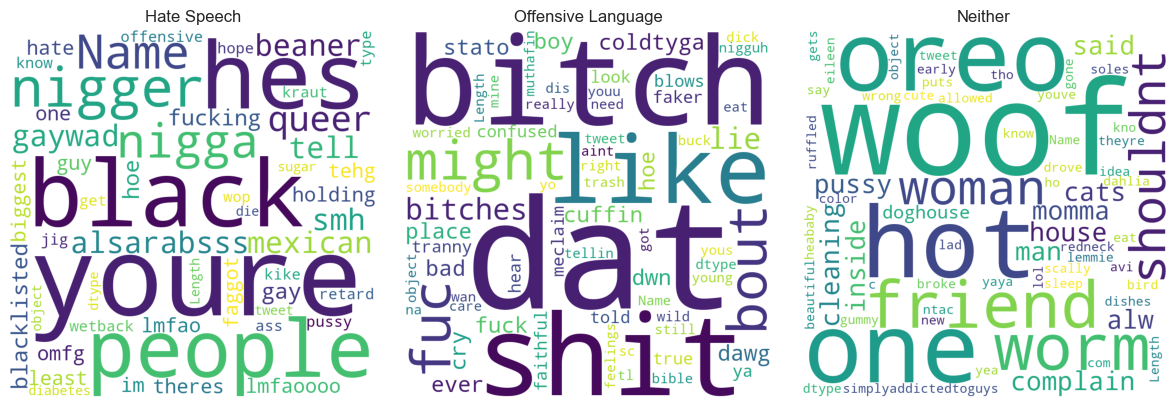

In [30]:
#wordclouds after removing duplicates and lemmatizing
fig, axs = plt.subplots(1,3,figsize=(12,4))

for category, ax in zip([0, 1, 2], axs.flatten()):
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',
                stopwords = stopword,
                min_font_size = 10,
                random_state=42, 
                max_words=200).generate(str(new_data.loc[new_data["class"]==category, 'tweet']))
    ax.imshow(wordcloud)
    ax.axis('off')

axs[0].set_title("Hate Speech")
axs[1].set_title("Offensive Language")
axs[2].set_title("Neither")

plt.tight_layout() 
plt.show()

## Part 3: Saving new data

In [31]:
new_data.to_csv("Data/processed_data.csv")